In [2]:
import tensorflow as tf  # 导入TF库
from tensorflow.keras import layers, optimizers, datasets, Sequential, metrics  # 导入TF子库
import os, glob
import random, csv
import matplotlib.pyplot as plt

In [3]:
# 创建图片路径和标签，并写入csv文件
def load_csv(root, filename, name2label):
    # root:数据集根目录
    # filename:csv文件名
    # name2label:类别名编码表
    if not os.path.exists(os.path.join(root, filename)):  # 如果不存在csv，则创建一个
        images = []  # 初始化存放图片路径的字符串数组
        for name in name2label.keys():  # 遍历所有子目录，获得所有图片的路径
            # glob文件名匹配模式，不用遍历整个目录判断而获得文件夹下所有同类文件
            # 只考虑后缀为png,jpg,jpeg的图片，比如：pokemon\\mewtwo\\00001.png
            images += glob.glob(os.path.join(root, name, '*.png'))
            images += glob.glob(os.path.join(root, name, '*.jpg'))
            images += glob.glob(os.path.join(root, name, '*.jpeg'))
        print(len(images), images)  # 打印出images的长度和所有图片路径名
        random.shuffle(images)  # 随机打乱存放顺序
        # 创建csv文件，并且写入图片路径和标签信息
        with open(os.path.join(root, filename), mode='w', newline='') as f:
            writer = csv.writer(f)
            for img in images:  # 遍历images中存放的每一个图片的路径，如pokemon\\mewtwo\\00001.png
                name = img.split(os.sep)[-2]  # 用\\分隔，取倒数第二项作为类名
                label = name2label[name]  # 找到类名键对应的值，作为标签
                writer.writerow([img, label])  # 写入csv文件，以逗号隔开，如：pokemon\\mewtwo\\00001.png, 2
            print('written into csv file:', filename)
    # 读csv文件
    images, labels = [], []  # 创建两个空数组，用来存放图片路径和标签
    with open(os.path.join(root, filename)) as f:
        reader = csv.reader(f)
        for row in reader:  # 逐行遍历csv文件
            img, label = row  # 每行信息包括图片路径和标签
            label = int(label)  # 强制类型转换为整型
            images.append(img)  # 插入到images数组的后面
            labels.append(label)
    assert len(images) == len(labels)  # 断言，判断images和labels的长度是否相同
    return images, labels

In [4]:
# 首先遍历pokemon根目录下的所有子目录。对每个子目录，用类别名作为编码表的key，编码表的长度作为类别的标签，存进name2label字典对象
def load_pokemon(root, mode='train'):
    # 创建数字编码表
    name2label = {}  # 创建一个空字典{key:value}，用来存放类别名和对应的标签
    for name in sorted(os.listdir(os.path.join(root))):  # 遍历根目录下的子目录，并排序
        if not os.path.isdir(os.path.join(root, name)):  # 如果不是文件夹，则跳过
            continue
        name2label[name] = len(name2label.keys())   # 给每个类别编码一个数字
    images, labels = load_csv(root, 'images.csv', name2label)  # 读取csv文件中已经写好的图片路径，和对应的标签
    # 将数据集按6：2：2的比例分成训练集、验证集、测试集
    if mode == 'train':  # 60%
        images = images[:int(0.6 * len(images))]
        labels = labels[:int(0.6 * len(labels))]
    elif mode == 'val':  # 20% = 60%->80%
        images = images[int(0.6 * len(images)):int(0.8 * len(images))]
        labels = labels[int(0.6 * len(labels)):int(0.8 * len(labels))]
    else:  # 20% = 80%->100%
        images = images[int(0.8 * len(images)):]
        labels = labels[int(0.8 * len(labels)):]
    return images, labels, name2label

In [5]:
img_mean = tf.constant([0.485, 0.456, 0.406])
img_std = tf.constant([0.229, 0.224, 0.225])

def normalize(x, mean=img_mean, std=img_std):
    x = (x - mean)/std
    return x

# def denormalize(x, mean=img_mean, std=img_std):
    # x = x * std + mean
    # return x

def preprocess(image_path, label):
    # x: 图片的路径，y：图片的数字编码
    x = tf.io.read_file(image_path)  # 读入图片
    x = tf.image.decode_jpeg(x, channels=3)  # 将原图解码为通道数为3的三维矩阵
    x = tf.image.resize(x, [244, 244])
    # 数据增强
    # x = tf.image.random_flip_up_down(x) # 上下翻转
    # x = tf.image.random_flip_left_right(x)  # 左右镜像
    x = tf.image.random_crop(x, [224, 224, 3])  # 裁剪
    x = tf.cast(x, dtype=tf.float32) / 255.  # 归一化
    x = normalize(x)
    y = tf.convert_to_tensor(label)  # 转换为张量
    return x, y


In [9]:
# 1.加载自定义数据集
images, labels, table = load_pokemon('../data/pokemon', 'train')
print('images', len(images), images)
print('labels', len(labels), labels)

1165 ['../data/pokemon/bulbasaur/00000158.png', '../data/pokemon/bulbasaur/00000170.png', '../data/pokemon/bulbasaur/00000212.png', '../data/pokemon/bulbasaur/00000004.png', '../data/pokemon/bulbasaur/00000010.png', '../data/pokemon/bulbasaur/00000011.png', '../data/pokemon/bulbasaur/00000005.png', '../data/pokemon/bulbasaur/00000171.png', '../data/pokemon/bulbasaur/00000173.png', '../data/pokemon/bulbasaur/00000211.png', '../data/pokemon/bulbasaur/00000013.png', '../data/pokemon/bulbasaur/00000012.png', '../data/pokemon/bulbasaur/00000204.png', '../data/pokemon/bulbasaur/00000189.png', '../data/pokemon/bulbasaur/00000162.png', '../data/pokemon/bulbasaur/00000176.png', '../data/pokemon/bulbasaur/00000228.png', '../data/pokemon/bulbasaur/00000016.png', '../data/pokemon/bulbasaur/00000002.png', '../data/pokemon/bulbasaur/00000003.png', '../data/pokemon/bulbasaur/00000017.png', '../data/pokemon/bulbasaur/00000201.png', '../data/pokemon/bulbasaur/00000215.png', '../data/pokemon/bulbasaur/0

In [10]:
print(table)

{'bulbasaur': 0, 'charmander': 1, 'mewtwo': 2, 'pikachu': 3, 'squirtle': 4}


In [11]:
db = tf.data.Dataset.from_tensor_slices((images, labels))  # images: string path， labels: number
db = db.shuffle(1000).map(preprocess,num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(32).repeat(20)

In [15]:
# 2.网络搭建
network = Sequential([
    # 第一层
    layers.Conv2D(48, kernel_size=11, strides=4, activation='relu'),  # 55*55*48
    layers.MaxPooling2D(pool_size=3, strides=2),  # 27*27*48
    # 第二层
    layers.Conv2D(128, kernel_size=5, strides=1, activation='relu'),  # 27*27*128
    layers.MaxPooling2D(pool_size=3, strides=2),  # 13*13*128
    # 第三层
    layers.Conv2D(192, kernel_size=3, strides=1, activation='relu'),  # 13*13*192
    # 第四层
    layers.Conv2D(192, kernel_size=3, strides=1, activation='relu'),  # 13*13*192
    # 第五层
    layers.Conv2D(128, kernel_size=3, strides=1, activation='relu'),  # 13*13*128
    layers.MaxPooling2D(pool_size=3, strides=2),  # 6*6*128
    layers.Flatten(),  # 6*6*128=4608
    # 第六层
    layers.Dense(1024, activation='relu'),
    layers.Dropout(rate=0.5),
    # 第七层
    layers.Dense(128, activation='relu'),
    layers.Dropout(rate=0.5),
    # 第八层（输出层）
    layers.Dense(5)
])
network.build(input_shape=(32, 224, 224, 3))  # 设置输入格式
network.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (32, 54, 54, 48)          17472     
                                                                 
 max_pooling2d_9 (MaxPoolin  (32, 26, 26, 48)          0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (32, 22, 22, 128)         153728    
                                                                 
 max_pooling2d_10 (MaxPooli  (32, 10, 10, 128)         0         
 ng2D)                                                           
                                                                 
 conv2d_17 (Conv2D)          (32, 8, 8, 192)           221376    
                                                                 
 conv2d_18 (Conv2D)          (32, 6, 6, 192)          

In [16]:
# 3.模型训练（计算梯度，迭代更新网络参数）
optimizer = optimizers.SGD(lr=0.01)  # 声明采用批量随机梯度下降方法，学习率=0.01
acc_meter = metrics.Accuracy()
x_step = []
y_accuracy = []
for step, (x, y) in enumerate(db):  # 一次输入batch组数据进行训练
    with tf.GradientTape() as tape:  # 构建梯度记录环境
        x = tf.reshape(x, (-1, 224, 224, 3))  # 将输入拉直，[b,28,28]->[b,784]
        out = network(x)  # 输出[b, 10]
        y_onehot = tf.one_hot(y, depth=5)  # one-hot编码
        loss = tf.square(out - y_onehot)
        loss = tf.reduce_sum(loss)/32  # 定义均方差损失函数，注意此处的32对应为batch的大小
        grads = tape.gradient(loss, network.trainable_variables)  # 计算网络中各个参数的梯度
        optimizer.apply_gradients(zip(grads, network.trainable_variables))  # 更新网络参数
        acc_meter.update_state(tf.argmax(out, axis=1), y)  # 比较预测值与标签，并计算精确度
    if step % 10 == 0:  # 每200个step，打印一次结果
        print('Step', step, ': Loss is: ', float(loss), ' Accuracy: ', acc_meter.result().numpy())
        x_step.append(step)
        y_accuracy.append(acc_meter.result().numpy())
        acc_meter.reset_states()

2023-09-21 17:04:23.067823: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:04:23.068020: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB
2023-09-21 17:04:24.347302: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:04:24.445181: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:04:24.658671: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:04:24.833730: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


Step 0 : Loss is:  0.9263951182365417  Accuracy:  0.125


2023-09-21 17:04:25.648135: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:04:26.253953: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:04:26.653965: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:04:26.804026: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:04:27.121085: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:04:27.269255: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:04:27.337313: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:04:28.286103: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:04:28.766867: W tensorflow/core/lib/png/png_io.cc:88] PNG 

Step 10 : Loss is:  0.7525119781494141  Accuracy:  0.296875


2023-09-21 17:04:34.575987: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:04:34.973989: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:04:35.887205: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:04:36.467000: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:04:36.467263: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB
2023-09-21 17:04:36.821089: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:04:37.387953: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:04:37.392418: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:04:37.536641: W tensorflow/core/lib/png/png_io.cc:88] PN

Step 20 : Loss is:  0.6861131191253662  Accuracy:  0.390625


2023-09-21 17:04:42.015697: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:04:43.093642: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:04:43.153980: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:04:43.223974: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:04:43.284817: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:04:45.162593: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:04:46.926425: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:04:47.696067: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:04:49.245943: W tensorflow/core/lib/png/png_io.cc:88] PNG 

Step 30 : Loss is:  0.6533771753311157  Accuracy:  0.5777778


2023-09-21 17:04:51.082063: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:04:51.148502: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:04:52.330907: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:04:53.311624: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:04:53.311823: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB
2023-09-21 17:04:54.086094: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:04:54.153314: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:04:54.170106: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:04:55.158596: W tensorflow/core/lib/png/png_io.cc:88] PN

Step 40 : Loss is:  0.4816319942474365  Accuracy:  0.675


2023-09-21 17:05:02.753550: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:05:02.967750: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:05:03.863982: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:05:04.329270: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:05:04.708646: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:05:04.708699: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB
2023-09-21 17:05:05.574693: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:05:06.681038: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:05:07.677769: W tensorflow/core/lib/png/png_io.cc:88] PN

Step 50 : Loss is:  0.37886351346969604  Accuracy:  0.6952381


2023-09-21 17:05:11.218977: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:05:12.330597: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:05:12.766040: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:05:12.862315: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:05:13.530672: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:05:13.530701: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB
2023-09-21 17:05:14.477987: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:05:14.517063: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:05:15.155398: W tensorflow/core/lib/png/png_io.cc:88] PN

Step 60 : Loss is:  0.5873517990112305  Accuracy:  0.703125


2023-09-21 17:05:19.960635: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:05:19.965169: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:05:20.792143: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:05:23.059838: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:05:23.702730: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:05:24.070852: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:05:24.447083: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:05:24.758036: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:05:25.878666: W tensorflow/core/lib/png/png_io.cc:88] PNG 

Step 70 : Loss is:  0.34360891580581665  Accuracy:  0.73650795


2023-09-21 17:05:29.267412: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:05:29.555845: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:05:29.557655: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB
2023-09-21 17:05:30.300156: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:05:31.287199: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:05:31.958326: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:05:32.020271: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:05:32.911096: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:05:33.550824: W tensorflow/core/lib/png/png_io.cc:88] PN

Step 80 : Loss is:  0.3078559339046478  Accuracy:  0.78125


2023-09-21 17:05:37.832650: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:05:37.832686: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB
2023-09-21 17:05:38.058065: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:05:38.098348: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:05:38.111755: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: too many profiles
2023-09-21 17:05:38.184178: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:05:38.189108: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:05:38.986184: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:05:43.108159: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: 

Step 90 : Loss is:  0.4263928532600403  Accuracy:  0.82222223


2023-09-21 17:05:46.206767: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:05:46.236942: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:05:46.401778: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:05:46.404334: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB
2023-09-21 17:05:46.958248: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: too many profiles
2023-09-21 17:05:47.952077: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:05:48.692877: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:05:48.793004: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:05:48.903132: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: 

Step 100 : Loss is:  0.3101516366004944  Accuracy:  0.775


2023-09-21 17:05:56.298745: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:05:56.457517: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:05:56.527591: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:05:57.251318: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:05:57.318122: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:05:58.279814: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:05:58.417840: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:05:59.223571: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:06:01.056892: W tensorflow/core/lib/png/png_io.cc:88] PNG 

Step 110 : Loss is:  0.23216506838798523  Accuracy:  0.8825397


2023-09-21 17:06:03.627033: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:06:05.047898: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:06:05.315836: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:06:05.382345: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:06:05.486866: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:06:06.109920: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:06:06.892377: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:06:07.977234: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:06:08.102358: W tensorflow/core/lib/png/png_io.cc:88] PNG 

Step 120 : Loss is:  0.30057641863822937  Accuracy:  0.865625


2023-09-21 17:06:13.878828: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: too many profiles
2023-09-21 17:06:16.741704: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:06:18.150878: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:06:18.218050: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:06:18.268238: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:06:18.839255: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:06:19.904857: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:06:19.911510: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:06:20.008034: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iC

Step 130 : Loss is:  0.43968498706817627  Accuracy:  0.834375


2023-09-21 17:06:25.065822: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:06:25.327911: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:06:25.697958: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:06:25.781180: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:06:25.860301: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:06:25.860357: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB
2023-09-21 17:06:26.770213: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:06:27.015637: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:06:28.136742: W tensorflow/core/lib/png/png_io.cc:88] PN

Step 140 : Loss is:  0.1631377786397934  Accuracy:  0.9047619


2023-09-21 17:06:33.086288: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:06:33.238573: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:06:33.898370: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:06:37.435145: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: too many profiles
2023-09-21 17:06:38.064913: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:06:38.251228: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:06:38.886764: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:06:39.559667: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:06:39.927744: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iC

Step 150 : Loss is:  0.16928458213806152  Accuracy:  0.853125


2023-09-21 17:06:42.935088: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:06:42.950218: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:06:42.953193: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:06:43.538529: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:06:43.903281: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:06:44.201103: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:06:44.201148: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB
2023-09-21 17:06:44.893102: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:06:45.583452: W tensorflow/core/lib/png/png_io.cc:88] PN

Step 160 : Loss is:  0.29987427592277527  Accuracy:  0.8698413


2023-09-21 17:06:49.395799: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:06:49.500717: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:06:49.500747: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB
2023-09-21 17:06:49.622974: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:06:50.968592: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:06:51.018182: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:06:52.075781: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:06:52.922228: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:06:53.513675: W tensorflow/core/lib/png/png_io.cc:88] PN

Step 170 : Loss is:  0.20876045525074005  Accuracy:  0.884375


2023-09-21 17:07:01.688434: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:07:01.688474: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB
2023-09-21 17:07:01.764700: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:07:01.791304: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:07:01.859092: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:07:02.240218: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:07:02.660114: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:07:02.722981: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:07:03.681828: W tensorflow/core/lib/png/png_io.cc:88] PN

Step 180 : Loss is:  0.08684204518795013  Accuracy:  0.9142857


2023-09-21 17:07:08.855099: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:07:08.946986: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:07:09.676260: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:07:10.011439: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:07:12.407411: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:07:13.362870: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:07:13.797569: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:07:14.291599: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:07:15.428547: W tensorflow/core/lib/png/png_io.cc:88] PNG 

Step 190 : Loss is:  0.2825081944465637  Accuracy:  0.85625


2023-09-21 17:07:17.115182: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:07:18.513420: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:07:21.316549: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:07:22.074995: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:07:22.542554: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:07:23.902281: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:07:23.902927: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB
2023-09-21 17:07:23.921665: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:07:23.967919: W tensorflow/core/lib/png/png_io.cc:88] PN

Step 200 : Loss is:  0.28403133153915405  Accuracy:  0.8634921


2023-09-21 17:07:24.820011: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:07:24.951173: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:07:25.005690: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:07:25.055225: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:07:26.189387: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:07:27.990923: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:07:29.920044: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:07:30.643495: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:07:30.749976: W tensorflow/core/lib/png/png_io.cc:88] PNG 

Step 210 : Loss is:  0.21565167605876923  Accuracy:  0.853125


2023-09-21 17:07:37.383583: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:07:38.700901: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:07:39.214150: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:07:39.993192: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: too many profiles
2023-09-21 17:07:41.542486: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:07:41.542527: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB
2023-09-21 17:07:43.916492: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:07:44.244448: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:07:49.393234: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: 

Step 220 : Loss is:  0.2404080331325531  Accuracy:  0.9142857


2023-09-21 17:07:52.574077: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:07:53.199133: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:07:54.104168: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:07:54.338357: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:07:54.686809: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:07:56.141817: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:07:56.340410: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:07:56.794221: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:07:57.407467: W tensorflow/core/lib/png/png_io.cc:88] PNG 

Step 230 : Loss is:  0.1449137032032013  Accuracy:  0.89375


2023-09-21 17:08:07.696548: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:08:07.793109: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:08:09.233716: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:08:10.595152: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:08:11.408039: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:08:11.679379: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:08:12.641351: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:08:14.172845: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:08:14.172882: W tensorflow/core/lib/png/png_io.cc:88] PNG 

Step 240 : Loss is:  0.18230533599853516  Accuracy:  0.9125


2023-09-21 17:08:17.402660: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:08:19.143223: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: too many profiles
2023-09-21 17:08:21.502104: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:08:21.512522: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:08:22.087885: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:08:23.604535: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:08:23.604568: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB
2023-09-21 17:08:23.837274: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:08:23.930023: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: 

Step 250 : Loss is:  0.2347247153520584  Accuracy:  0.8761905


2023-09-21 17:08:31.887886: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:08:31.918454: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:08:33.326186: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:08:34.848945: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:08:34.999559: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:08:35.928811: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:08:36.835807: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:08:36.917894: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:08:36.918816: W tensorflow/core/lib/png/png_io.cc:88] PNG 

Step 260 : Loss is:  0.12355822324752808  Accuracy:  0.91875


2023-09-21 17:08:44.791973: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:08:44.883853: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:08:45.029260: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:08:45.831399: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:08:47.069277: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:08:47.944486: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: too many profiles
2023-09-21 17:08:48.288575: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:08:48.383810: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:08:49.214714: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iC

Step 270 : Loss is:  0.13009455800056458  Accuracy:  0.9142857


2023-09-21 17:08:53.998563: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:08:54.129754: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:08:54.213067: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:08:55.073192: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:08:57.396134: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:08:57.409803: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:08:58.145269: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:08:58.277719: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:08:58.291216: W tensorflow/core/lib/png/png_io.cc:88] PNG 

Step 280 : Loss is:  0.1490914523601532  Accuracy:  0.9


2023-09-21 17:09:03.132915: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:09:03.424574: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:09:03.586112: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:09:03.695356: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:09:03.822401: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:09:04.144871: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:09:04.390901: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:09:04.573459: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:09:04.914384: W tensorflow/core/lib/png/png_io.cc:88] PNG 

Step 290 : Loss is:  0.247897207736969  Accuracy:  0.93015873


2023-09-21 17:09:09.089360: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:09:09.867675: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:09:10.788128: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: too many profiles
2023-09-21 17:09:10.866311: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:09:11.462495: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:09:11.462523: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB
2023-09-21 17:09:12.573617: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:09:13.379892: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:09:13.948310: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: 

Step 300 : Loss is:  0.17238572239875793  Accuracy:  0.89375


2023-09-21 17:09:21.677938: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:09:21.679612: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:09:21.701157: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:09:21.701271: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB
2023-09-21 17:09:22.326447: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:09:23.325881: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:09:23.375684: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:09:24.706505: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:09:24.709556: W tensorflow/core/lib/png/png_io.cc:88] PN

Step 310 : Loss is:  0.11578626930713654  Accuracy:  0.9174603


2023-09-21 17:09:26.224260: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: too many profiles
2023-09-21 17:09:26.334211: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:09:26.567010: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:09:28.074241: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:09:28.819933: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:09:29.061179: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:09:30.549137: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:09:31.315342: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:09:31.335803: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iC

Step 320 : Loss is:  0.2786158621311188  Accuracy:  0.903125


2023-09-21 17:09:35.147108: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:09:35.171404: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:09:35.398857: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:09:36.893270: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:09:37.984421: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:09:38.744220: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:09:40.709237: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:09:40.715428: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:09:41.122084: W tensorflow/core/lib/png/png_io.cc:88] PNG 

Step 330 : Loss is:  0.11822296679019928  Accuracy:  0.8984127


2023-09-21 17:09:43.763405: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:09:44.498272: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:09:46.367303: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:09:47.523896: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:09:47.721422: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:09:48.700536: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:09:49.403157: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:09:49.433085: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:09:49.512772: W tensorflow/core/lib/png/png_io.cc:88] PNG 

Step 340 : Loss is:  0.25289440155029297  Accuracy:  0.90625


2023-09-21 17:09:53.559476: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:09:53.559510: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB
2023-09-21 17:09:54.437008: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:09:54.712727: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:09:55.525671: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:09:56.585646: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:09:57.092351: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:09:57.277383: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:09:57.778436: W tensorflow/core/lib/png/png_io.cc:88] PN

Step 350 : Loss is:  0.2506527304649353  Accuracy:  0.90625


2023-09-21 17:10:03.027933: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:10:03.103231: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:10:03.160359: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:10:03.262293: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: too many profiles
2023-09-21 17:10:03.791383: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:10:04.416360: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:10:06.513376: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:10:06.743753: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:10:06.778957: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iC

Step 360 : Loss is:  0.11094973236322403  Accuracy:  0.94920635


2023-09-21 17:10:13.456510: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:10:13.733104: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:10:14.397645: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:10:14.397679: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB
2023-09-21 17:10:15.356486: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:10:16.252443: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:10:17.067824: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:10:18.115967: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:10:19.901794: W tensorflow/core/lib/png/png_io.cc:88] PN

Step 370 : Loss is:  0.21656569838523865  Accuracy:  0.9


2023-09-21 17:10:23.310722: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:10:23.618281: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:10:23.741447: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:10:23.741593: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB
2023-09-21 17:10:23.980174: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:10:24.224526: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:10:25.212480: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:10:25.406039: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:10:25.774462: W tensorflow/core/lib/png/png_io.cc:88] PN

Step 380 : Loss is:  0.1309572011232376  Accuracy:  0.9047619


2023-09-21 17:10:32.623894: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:10:34.035995: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:10:34.097304: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:10:34.880246: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:10:35.133711: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:10:35.808528: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:10:35.905774: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:10:36.663347: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:10:36.678988: W tensorflow/core/lib/png/png_io.cc:88] PNG 

Step 390 : Loss is:  0.14456303417682648  Accuracy:  0.93125


2023-09-21 17:10:40.864100: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:10:40.873678: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:10:43.597368: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:10:44.698324: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:10:45.513428: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:10:45.603071: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:10:46.948802: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:10:47.659643: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:10:47.852025: W tensorflow/core/lib/png/png_io.cc:88] PNG 

Step 400 : Loss is:  0.15518108010292053  Accuracy:  0.93015873


2023-09-21 17:10:49.249763: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:10:49.304476: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:10:49.715961: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:10:50.398306: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:10:50.423136: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:10:50.423192: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB
2023-09-21 17:10:53.500093: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:10:53.684883: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:10:54.269929: W tensorflow/core/lib/png/png_io.cc:88] PN

Step 410 : Loss is:  0.0682540014386177  Accuracy:  0.93125


2023-09-21 17:11:00.667541: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:11:00.734542: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: too many profiles
2023-09-21 17:11:00.743789: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:11:04.675901: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:11:06.650263: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:11:06.650302: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB
2023-09-21 17:11:07.206089: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:11:08.002738: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:11:08.093348: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: 

Step 420 : Loss is:  0.05939492955803871  Accuracy:  0.93333334


2023-09-21 17:11:09.752145: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:11:10.057522: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:11:11.433386: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:11:11.588070: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:11:11.755136: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:11:12.554546: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:11:13.164754: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:11:13.164786: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB
2023-09-21 17:11:14.133166: W tensorflow/core/lib/png/png_io.cc:88] PN

Step 430 : Loss is:  0.10712166130542755  Accuracy:  0.915625


2023-09-21 17:11:18.308388: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:11:18.438167: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:11:18.484922: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:11:18.638540: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:11:18.758114: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:11:19.619929: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:11:20.951483: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:11:21.208879: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-21 17:11:21.790965: W tensorflow/core/lib/png/png_io.cc:88] PNG 

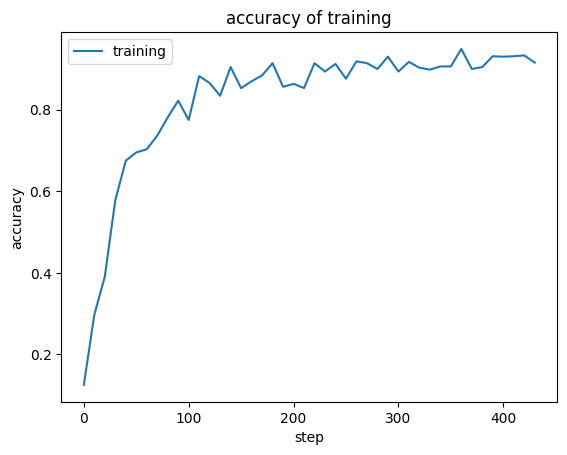

In [17]:
# 4.可视化
plt.plot(x_step, y_accuracy, label="training")
plt.xlabel("step")
plt.ylabel("accuracy")
plt.title("accuracy of training")
plt.legend()
plt.show()